<a href="https://colab.research.google.com/github/martinfranzner/Stock/blob/main/StocksMartinFranzner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo de Previsão e Negociação - Martin Franzner

O algoritmo é baseado em obter os dados de um ativo, como SP500, Nikkei 255 e também demais índices.
Com os dados é gerado diversos indicadores.
Os indicadores escolhidos e seus parâmetros foram escolhidos de acordo com um algoritmo genético onde ele obtém as melhores combinações de parâmetros e indicadores.(Detalhe: o algoritmo genético não é executado aqui, os parâmetros e indicadores já são setados conforme o algoritmo genético retornou anteriormente.)

## Funcionamento do Algoritmo
Basicamente, o foco do programa é prever se o ativo vai subir ou descer em X dias. No caso o melhor resultado de previsão foi no valor de prever 1 dia para frente.
Então é rodado um algoritmo de machine learning para treinar o classificador com os dados.

Após treinado, é executado um algoritmo de negociação, com os dados que não foram treinados, assim para validar não somente a acurácia do classificar, mas se ele se faz útil para a previsão de negocição, basicamente o trade, a compra e a venda. Focando no lucro.



##Como rodar?
Clique nas células e aperte: Shift + Enter

Você verá que a célula é executada.


Célula para instalar o módulo que chama a api do yahoo finance

In [1]:
pip install yfinance

     |████████████████████████████████| 5.5MB 13.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=4d7d0f2ad75bfa8587ab34c8cfc4112a35e9170d3f2cc2f3efb4a8bac097cd1e
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


Importação dos pacotes necessários do python

In [2]:
import pandas as pd
print(pd.__version__)
import numpy  
import matplotlib.pyplot as plt
from statistics import mean
from itertools import islice
import math as m
#from pandas.stats import moments
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

pd.set_option('display.max_columns', 500)
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

1.1.4


#Escolha do ativo
###Função que carrega os dados do ativo e prepara o Dataframe
Por exemplo, se quiseres mudar de ativo, somente mude o ticker.

Detalhe, o ticker sempre deve estar nesse formato: **ticker = "^N225"**
Exemplo do SP500: **ticker = "^GSPC"**

Para mudar é somente trocar no código abaixo, mas lembre que deve seguir o padrão dos tickers do yahoo finance.

Também é possível escolher a data, com o "start e "end", o inicio e o final. Lembre que a data tem que fazer sentido com o que o ativo é negociado.

In [3]:
ticker = "^BVSP"

def prepareDF():
    df = yf.download(ticker, start="1990-10-02", end="2020-10-27")
    df = df.reset_index() 
    #df = pd.read_csv(jap,  lineterminator='\n',)
    #print(df.head(5)) 
    #if(df.isnull().values.any()):
        
        #return False
    #else:
    #df = df.dropna()
    

    return df

# INDICADORES
Abaixo é realizado a instanciação das funções que inserem os indicadores no dataframe.

In [4]:
def ADX(df, n, n_ADX):  
    i = 0  
    UpI = []  
    DoI = []  
    while i + 1 <= df.index[-1]:  
        # UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        # DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')  
        UpMove = df.at[(i + 1), 'High'] - df.at[i, 'High']
        DoMove = df.at[i, 'Low'] - df.at[(i + 1), 'Low'] 
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        # TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'High')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Adj Close'))
        TR = max(df.at[(i + 1), 'High'], df.at[i, 'High']) - min(df.at[(i + 1), 'Low'], df.at[i, 'Adj Close'])  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(TR_s.ewm( span = n, min_periods = n).mean())  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(UpI.ewm(span = n, min_periods = n - 1).mean() / ATR)  
    NegDI = pd.Series(DoI.ewm(span = n, min_periods = n - 1).mean() / ATR)  
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span = n_ADX, min_periods = n_ADX - 1).mean(), name = 'ADX_' + str(n) + '_' + str(n_ADX))  
    df = df.join(ADX)  
    return df

def DINeg(df, n):  
    n_ADX = n
    i = 0  
    UpI = []  
    DoI = []  
    while i + 1 <= df.index[-1]:  
        # UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        # DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')
        UpMove = df.at[(i + 1), 'High'] - df.at[i, 'High']  
        DoMove = df.at[i, 'Low'] - df.at[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        # TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'High')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Adj Close'))  
        TR = max(df.at[(i + 1), 'High'], df.at[i, 'High']) - min(df.at[i + 1, 'Low'], df.at[i, 'Adj Close'])  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(TR_s.ewm( span = n, min_periods = n).mean())  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    #PosDI = pd.Series(UpI.ewm(span = n, min_periods = n - 1).mean() / ATR)  
    NegDI = pd.Series(DoI.ewm(span = n, min_periods = n - 1).mean() / ATR, name = 'DINeg_' + str(n))  
    #ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span = n_ADX, min_periods = n_ADX - 1).mean(), name = 'ADX_' + str(n) + '_' + str(n_ADX))  
    df = df.join(NegDI)  
    return df

def RSI(df, n):  
    i = 0  
    UpI = [0]  
    DoI = [0]  
    while i + 1 <= df.index[-1]:  
        # UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        # DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')
        UpMove = df.at[(i + 1), 'High'] - df.at[i, 'High']  
        DoMove = df.at[i, 'Low'] - df.at[i + 1, 'Low']  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(UpI.ewm(span = n, min_periods = n - 1).mean())  
    NegDI = pd.Series(DoI.ewm(span = n, min_periods = n - 1).mean())  
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))  
    df = df.join(RSI)  
    return df

def STOK(df,n):  
    SOk = pd.Series(((df['Adj Close'] - df['Low'].rolling(n).min()) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min())*100), name = 'SO%k_'+str(n))  
    df = df.join(SOk)  
    return df

def WMA(df,n):
    weights = numpy.arange(1,n+1) #this creates an array with integers 1 to 10 included
    wma = df['Adj Close'].rolling(n).apply(lambda prices: numpy.dot(prices, weights)/weights.sum(), raw=True)
    # print("WMA:",wma)
    df['WMA'] = wma
    
    return df

def WilliamsR(df,n):
    wr = pd.Series(((df['High'].rolling(n).max() - df['Adj Close']) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min())*-100), name = 'Wil%r_'+str(n)) 
    df = df.join(wr)
    
    return df

def AroonUp(df,n):
    #Formula: (N - Number of periods since highest high)/N * 100
    arUp = pd.Series((((n - (n - (df['High'].rolling(n).apply(numpy.argmax)+1))) / n )  *100), name = 'AroonUp_'+str(n))
    df = df.join(arUp)
    
    return df

def VWAP(df):
    
    df['VWAP'] = numpy.cumsum(df['Volume']*(df['High']+df['Low'])/2) / numpy.cumsum(df['Volume'])
    
    return df

def setLabels(df,forecastDays):
    wSize = forecastDays # number of days to forecast
    
    #i=0
    #cond = 100
    #dfShifted = df['<CLOSE>'].shift(-wSize)
    #df['LABEL'] = ((df['<CLOSE>'].shift(-wSize) - df['<CLOSE>'])/df['<CLOSE>'])
    
    #df['LABEL'] = ((df['Adj Close'].shift(-wSize) - df['Adj Close'])/df['Adj Close']).apply(lambda x: 1 if x > 0.0001 else -1)
    
    df['LABEL'] = (df['Adj Close'].shift(-wSize) - df['Adj Close']).apply(lambda x: 1 if x > 0.0 else -1)

            
    return df

# Algoritmo de Negocição
- O montante incial é $100 mil
- Ele somente executa a compra ou venda quando o forecast do algoritmo indicar mais de 60% de confiança, tanto para venda ou para compra.

* Regras do jogo:
  * Compra a ação quando a classificação indicar que a ação irá subir no dia seguinte e tiver dinheiro em caixa, comprando a quantidade máxima de ações que a quantidade de dinheiro permitir; 

  * Vende todas as ações quando a classificação apontar que o dia seguinte a ação irá cair e se tiver ações compradas; 

  * Mantém as ações compradas se a classificação apontar para uma alta no dia seguinte e o algoritmo tiver as ações compradas; 

  * Mantém sem comprar ações se a classificação apontar para queda no próximo dia e não tiver ações compradas. 



In [5]:
def negotiationAlgo(predictions,df,trainLength): 
    '''
    Rule of the game:
        * Compra a ação quando a classificação indicar que a ação irá subir no dia seguinte e tiver dinheiro em caixa, comprando a quantidade máxima de ações que a quantidade de dinheiro permitir; 

        * Vende todas as ações quando a classificação apontar que o dia seguinte a ação irá cair e se tiver ações compradas; 

        * Mantém as ações compradas se a classificação apontar para uma alta no dia seguinte e o algoritmo tiver as ações compradas; 

        * Mantém sem comprar ações se a classificação apontar para queda no próximo dia e não tiver ações compradas. 
    '''
    print("\n\n---------------- ALGORITMO DE NEGOCIAÇÃO -------------\n")
    
    dfBuysSells = pd.DataFrame(columns=['Date', 'Price','Operation','Quantity','AvailableBalance','Moment Position'])
    #print("dfBuysSells")
    #print(dfBuysSells)
    
    position = []
    #initial money
    valueFree = 100000.0
    qtyOfStocks = 0
    qtyStockSold = 0
    priceWhenSold = 0
    #print("Starts negotiation after # days:",trainLength)
    dfToAnalize = df[trainLength:]
    #print("Days left o analyse")
    #print(len(dfToAnalize))
    dfToAnalize = dfToAnalize.reset_index() 
    #print("DF to Analize")
    #print(dfToAnalize.head(30))
    i=0
    while i < len(dfToAnalize):
        
        if(predictions[i][0]) <= 0.40:#means the positive class is more than 60% and negative is less than 40% chance
            
            #BUY ORDER
            price = dfToAnalize['Adj Close'][i]
            date = dfToAnalize['Date'][i]
 
            if(valueFree > price):
                
                qty = int(valueFree / price) #return how many stocks the money can buy
                qtyOfStocks = qtyOfStocks + qty
                valueFree = valueFree - qty*price #return with how much money left after buying
                momentPosition = valueFree + (price*qtyOfStocks)
                momentPosition = round(momentPosition,2)
                if(qty > 0): #just double checking before add new row to buyNsell Dataframe
                    new_row = {'Date': date,'Price': price,'Operation': 'Buy','Quantity':qtyOfStocks,'AvailableBalance':valueFree,'Moment Position':momentPosition}#'IndexInOriginal':trainLength+i-1}  
                    dfBuysSells = dfBuysSells.append(new_row,ignore_index=True)
                
        elif(predictions[i][0]) >= 0.60: #this means the negative class has to be more tha 60% and positive less than 40% chance
            #SELL ORDER    
            price = dfToAnalize['Adj Close'][i]
            date = dfToAnalize['Date'][i]
            if(qtyOfStocks > 0):
                valueFree =  valueFree + qtyOfStocks*price
                momentPosition = valueFree + (price*qtyOfStocks)
                momentPosition = round(momentPosition,2)
                new_row = {'Date': date,'Price': price,'Operation': 'Sell','Quantity':qtyOfStocks,'AvailableBalance':valueFree,'Moment Position':momentPosition} #'IndexInOriginal':trainLength+i-1}  
                qtyOfStocks = 0
                dfBuysSells = dfBuysSells.append(new_row,ignore_index=True)

            
                
        position.append(valueFree + dfToAnalize['Adj Close'][i]*qtyOfStocks )
        if(i % 100 == 0):
            print("Iteration number - Iteraçao número:",i)
            print('Data: ',dfToAnalize['Date'][i])
            print('Position - Posicao atual:',valueFree + dfToAnalize['Adj Close'][i]*qtyOfStocks,)
            print('Qty Stocks - Quantidade de papeis:',qtyOfStocks)
            print("-------------------")
        i = i+1
        
    print('Qty of operations - Quantidade de operações:', len(dfBuysSells))
    #print("Len position",len(position))
    print("Position actual",position[-1])
    #print("Iterator i:",i)
    print("\n\n -------------------- Dataframe de todas compras e vendas --------------\n")
    print(dfBuysSells)
    
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('days')
    ax1.set_ylabel('position', color=color)
    ax1.plot(numpy.linspace(1,len(position),len(position)), position, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(ticker, color=color)  # we already handled the x-label with ax1
    ax2.plot(numpy.linspace(1,len(position),len(position)), dfToAnalize['Adj Close'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    #plt.plot(numpy.linspace(1,len(position),len(position)),position)
    #plt.ylabel('Position')
    #plt.show()
    
    print("Final Value Available - Valor Final Disponível:", position[-1])
    print("Final Gain - Ganho final:", position[-1]/100000.0)
    print("Max drawdown - Máximo de perda:", (100000 - min(position)))
    print("Min position value - Menor posição durante o período:", min(position))


#Execução do script principal que faz o algoritmo

Note que os resultados vão ser escrito abaixo da célula

[*********************100%***********************]  1 of 1 completed
Quantidade de predições positivas e negativas


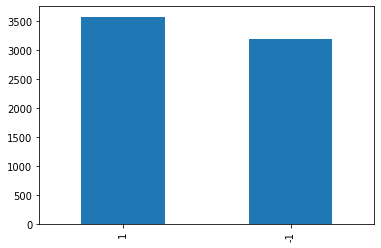

1:prox dia positivo,  -1:proximo dia negativo


Porcentagem da base de teste usada para TREINAR o classificador: 80%
Porcentagem da base de teste usada para TESTAR o classificador: 20%

Train length - Quantidade de treinamento: 5421 5421
Test length - Quantidade de teste: 1356 1356 

Trained from - Treinou de: 1993-05-31 00:00:00 to - até 2015-04-29 00:00:00
Tested from - Testou de: 2015-04-30 00:00:00 to - até 2020-10-23 00:00:00 

Predictions length - Quantidade de predições: 1356 

Instances with 0.5 accuracy each class - Instancias com predição de 50% cada classe: 38.0 

Accuracy Train - Acurácia durante treino: 0.9998155321896329
Accuracy of classifier - Acurácia durante teste : 0.668141592920354 

Confusion Matrix -  Matriz de Confusão
     -1    1
-1  489  157
 1  293  417

Features Importance - Ordem de importancia dos indicadores
DINeg_6       0.273217
RSI_7         0.135775
ADX_6_6       0.120240
Wil%r_10      0.114361
SO%k_15       0.110924
Adj Close     0.093788
WMA        

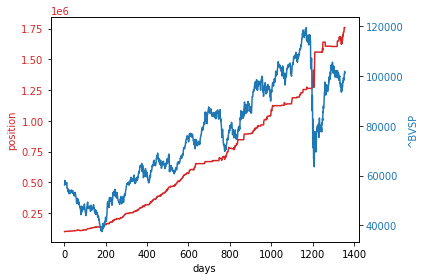

Final Value Available - Valor Final Disponível: 1758840.0
Final Gain - Ganho final: 17.5884
Max drawdown - Máximo de perda: 0.0
Min position value - Menor posição durante o período: 100000.0


In [6]:
#prepara o dataframe
df = prepareDF()


#insere os indicadores
df= ADX(df,6,6)
df= RSI(df,7)
df= STOK(df,15)
df= WMA(df,6)
df= DINeg(df,6)
df = WilliamsR(df,10)
df = AroonUp(df,25)
#df = VWAP(df)

df = df.dropna()
df = df.reset_index() 


#seta em quantos dias a frente decide fazer o forecast
df = setLabels(df,1)
#grafico que mostra quantas vezes, caiu ou subiu o ativo comparado com o proximo dia.
print("Quantidade de predições positivas e negativas")
df['LABEL'].value_counts().plot.bar()
plt.show()
print("1:prox dia positivo,  -1:proximo dia negativo\n\n")


#prepara o dataframe para o algoritmo de classificação
y = df['LABEL']
X = df.drop(columns=['LABEL','Date','High','Low','Close','Open','Volume','index'])
#X = df.drop(columns=['LABEL','Date','High','Low','Close','Open',])
feature_names = list(X.columns.values)

#aqui é treinado 80% da base de teste e testada 20%
print("Porcentagem da base de teste usada para TREINAR o classificador: 80%")
print("Porcentagem da base de teste usada para TESTAR o classificador: 20%\n")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)#shuffle=False

print("Train length - Quantidade de treinamento:",len(X_train),len(y_train))
print("Test length - Quantidade de teste:",len(X_test),len(y_test),'\n')
print("Trained from - Treinou de:",df['Date'][0], 'to - até', df['Date'][len(X_train)-1])
print("Tested from - Testou de:",df['Date'][len(X_train)], 'to - até', df['Date'][len(X_train)+len(X_test)-1],'\n')

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=80)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
 
predictions = clf.predict_proba(X_test)
#print("Prediction - ytest")
#print(predictions,y_test)

print('Predictions length - Quantidade de predições:', len(predictions),'\n')

# Model Accuracy, how often is the classifier correct?
print("Instances with 0.5 accuracy each class - Instancias com predição de 50% cada classe:",(numpy.count_nonzero(predictions == 0.50)/2),'\n')
print("Accuracy Train - Acurácia durante treino:", clf.score(X_train, y_train))
print("Accuracy of classifier - Acurácia durante teste :",metrics.accuracy_score(y_test, y_pred),'\n')

labels = numpy.unique(y_test)

a = confusion_matrix(y_test, y_pred, labels=labels)

print("Confusion Matrix -  Matriz de Confusão")
print(pd.DataFrame(a, index=labels, columns=labels))

feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
print("\nFeatures Importance - Ordem de importancia dos indicadores")
print(feature_imp)


#print('Preditc of last 5 days:', clf.predict_proba(X_test.tail()))
''''
print('\n---------------  SVC ------------------\n')
clf = svm.SVC(kernel='poly') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test,y_pred))

a =  confusion_matrix(y_test, y_pred, labels=labels)


print(pd.DataFrame(a, index=labels, columns=labels))
''' 



negotiationAlgo(predictions,df,len(X_train))